In [1]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d

In [2]:
N_skin = 400
N_bandage = 50
control_trajectory = np.array([[-0.4677,  0.0367,  0.1300],
                               [-0.4,  0.0367,  0.2000],
                               [-0.3,  0.0367,  0.27],
                               [-0.2,  0.0367,  0.33],
                               [-0.0,  0.0367,  0.38],
                               [0.2,  0.0367,  0.38],
                               [0.4,  0.0367,  0.38],
                               [0.6,  0.0367,  0.38]])

In [3]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), 10 * control_trajectory.shape[0])  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)

In [4]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(x_length=1, y_length=0.8, z_length=0.24), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Plane(center=(0, 0, skin_mesh.points[:, 2].max()+0.01), i_size=1, j_size=0.3), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
# softbody.init_rigid_constraints(1, 0.3)
softbody.init_shape_constraints_thinshell([1])
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, 0, 2)
softbody.fix_point(1, 25)
softbody.add_multi_boundary_constrain(1, 0, 0.1, range(50))

detect 2 object


In [5]:
softbody.C_boundary_list[0]

tensor([[400,  21],
        [400,  47],
        [400, 306],
        [400, 307],
        [400,  48],
        [400,  46],
        [401, 309],
        [401, 306],
        [401, 307],
        [401, 308],
        [402, 309],
        [402, 341],
        [402, 308],
        [402, 355],
        [402, 310],
        [402, 302],
        [403, 348],
        [403, 355],
        [403, 356],
        [403, 310],
        [403, 302],
        [403, 352],
        [404, 348],
        [404, 356],
        [404, 352],
        [404, 354],
        [404, 351],
        [405, 354],
        [405, 351],
        [405, 319],
        [405, 323],
        [405, 321],
        [406, 321],
        [406, 324],
        [406, 322],
        [406, 320],
        [407, 389],
        [407, 324],
        [407, 325],
        [407, 322],
        [407, 326],
        [408, 389],
        [408, 326],
        [408, 391],
        [408, 392],
        [409, 391],
        [409, 392],
        [409, 383],
        [409, 387],
        [409, 386],


In [6]:
softbody.V[425]

tensor([-0.4677,  0.0367,  0.1300])

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


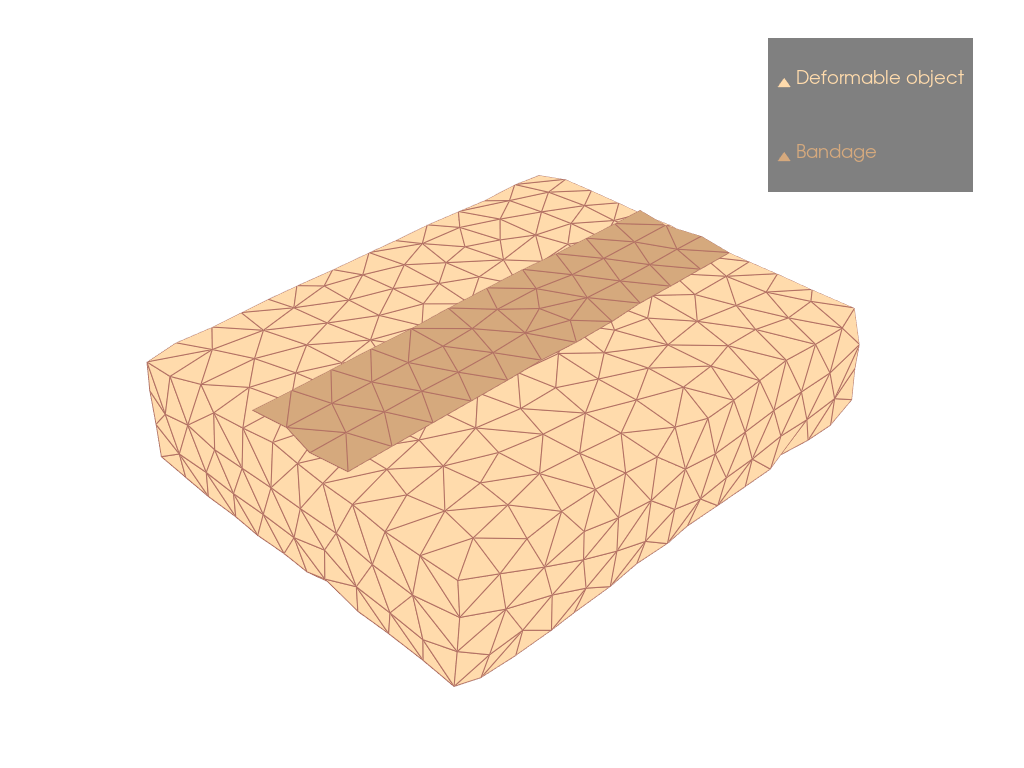

In [7]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [8]:
# softbody.fix_point(1, 1)

In [9]:
cloth_dist_stiffness = 1e3
V_boundary_stiffness = 1e3
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*3

In [10]:
V_boundary_stiffness.shape

torch.Size([251, 1])

In [11]:
pl.open_gif('skin_bandage.gif')
for i in range(control_trajectory.shape[0]):
    softbody.V[softbody.offset_list[1] + 25] = control_trajectory[i]
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=True,
                use_spring_boundary=True,
                use_dist=True) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
    V_boundary_stiffness[energy.squeeze() > 0.5] = 1e-8
    # print(energy)
    skin_mesh.points = softbody.V[:N_skin].cpu().numpy()
    bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].cpu().numpy()
    # pl.remove_actor(bandage_actor)
    # bandage_actor = pl.add_points(softbody.V[N_skin:N_skin+N_bandage].cpu().numpy(), color='r')
    pl.write_frame()
pl.close()